_Disclosure_ In order to more efficiently build this notebook and to avoid computational issues when running the code (such as having the session crash due to insufficient RAM) we used a subset of the original dataset found here: https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database. We first sampled 5% of users and then randomly selected 35,000 of those ratings to reach the final dataset we used for the project.

# Set up

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ratings = pd.read_csv('anime_ratings.csv')
anime = pd.read_csv('data/anime.csv')

# Exploratory Data Analysis

## Ratings Data

In [6]:
ratings.head()

,user_id,anime_id,rating
0,34992,903,9
1,11536,11697,8
2,7367,509,8
3,73436,4835,10
4,73308,7088,8


In [7]:
print(f"There are {ratings['user_id'].nunique()} unique users")
print(f"There are {ratings['anime_id'].nunique()} unique anime shows")
print(f"There are {ratings.shape[0]} ratings")

There are 2892 unique users
There are 4326 unique anime shows
There are 35000 ratings


In [8]:
print("=== Ratings Dataset Info ===")
print(ratings.info())
print(ratings.describe())
print("Missing values in ratings:")
print(ratings.isnull().sum())

=== Ratings Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35000 entries, 0 to 34999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   user_id   35000 non-null  int64
 1   anime_id  35000 non-null  int64
 2   rating    35000 non-null  int64
dtypes: int64(3)
memory usage: 820.4 KB
None
            user_id      anime_id        rating
count  35000.000000  35000.000000  35000.000000
mean   36775.910914   9039.556257      7.822600
std    21029.988850   8954.059710      1.556185
min       18.000000      1.000000      1.000000
25%    18600.000000   1316.000000      7.000000
50%    37746.000000   6347.000000      8.000000
75%    54713.000000  14345.000000      9.000000
max    73510.000000  34240.000000     10.000000
Missing values in ratings:
user_id     0
anime_id    0
rating      0
dtype: int64


No missing values to take care of

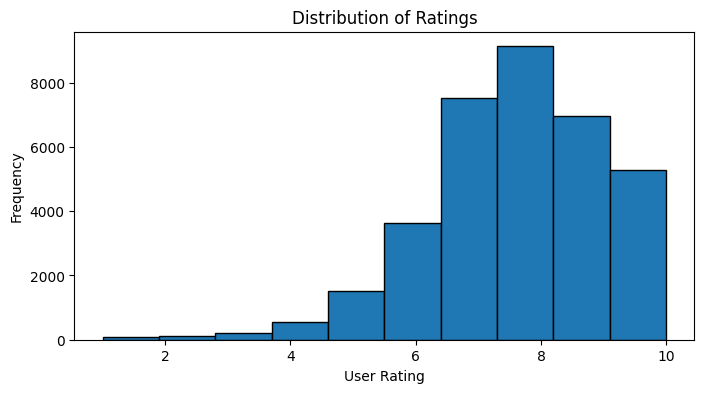

In [10]:
# a. Distribution of Ratings

plt.figure(figsize=(8, 4))
plt.hist(ratings['rating'], edgecolor='black')
plt.title("Distribution of Ratings")
plt.xlabel("User Rating")
plt.ylabel("Frequency")
plt.show()

The distribution of the ratings is extremely left skewed, with most ratings between 7 and 10, and very few below. This could potentially affect the acuracy of recommenders since it might be hard for the models to learn when to predict lower scores and migght be biased towards predicting good ratings. 
A possible mitigation strategy when building the recommenders could be to add bias adjustments to calibrate recommendations.

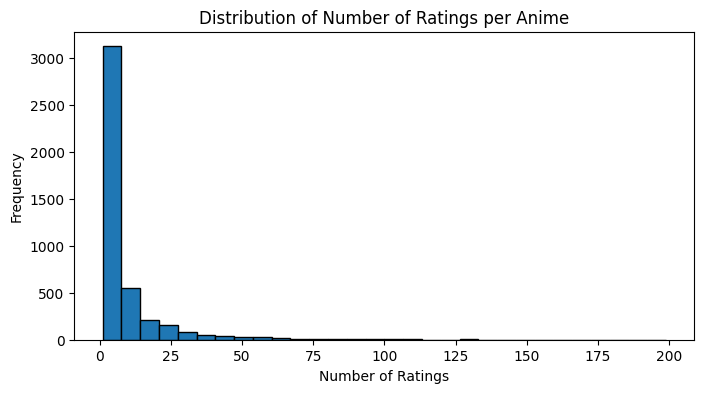

34.70285714285714


In [12]:
# b. Distribution of Number of Ratings per Anime

ratings_count = ratings['anime_id'].value_counts()
plt.figure(figsize=(8, 4))
plt.hist(ratings_count, bins=30, edgecolor='black')
plt.title("Distribution of Number of Ratings per Anime")
plt.xlabel("Number of Ratings")
plt.ylabel("Frequency")
plt.show()

n_anime = ratings['anime_id'].nunique()
print(ratings.groupby('anime_id').size().sort_values(ascending=False).cumsum().iloc[int(n_anime*0.05)] / ratings.shape[0] * 100)

The histogram is heavily right-skewed, indicating that a few anime are extremely popular, while the majority have only a few ratings. This clearly illustrates the long-tail phenomenon: a few top items are responsible for a great percentage of interactions; here, the top 5% of animes are responsible for nearly 35% of the ratings.

This popularity bias can lead to the cold-start problem for those items with very few/no interactions. It is important to keep this in mind when building the recommenders.

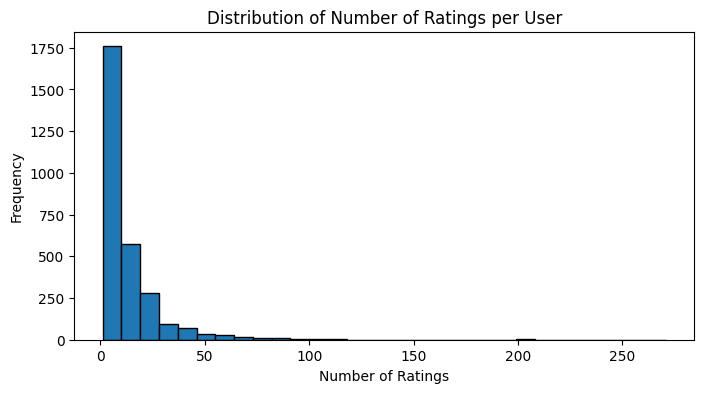

27.22


In [13]:
# c. Distribution of Number of Ratings per User

ratings_count = ratings['user_id'].value_counts()
plt.figure(figsize=(8, 4))
plt.hist(ratings_count, bins=30, edgecolor='black')
plt.title("Distribution of Number of Ratings per User")
plt.xlabel("Number of Ratings")
plt.ylabel("Frequency")
plt.show()

n_users = ratings['user_id'].nunique()
print(ratings.groupby('anime_id').size().sort_values(ascending=False).cumsum().iloc[int(n_users*0.05)] / ratings.shape[0] * 100)

Once again, we observe a strongly right-skewed distribution. We can therefore also see the long tail phenomenon present with respect to users, although slightly less strong than with items. In this case, the top 5% users account for nearly 30% of ratings.

## Anime Data

In [14]:
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [15]:
print("\n=== Anime Dataset Info ===")
print(anime.info())
print(anime.describe(include='all'))
print("Missing values in anime:")
print(anime.isnull().sum())


=== Anime Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB
None
            anime_id                     name   genre   type episodes  \
count   12294.000000                    12294   12232  12269    12294   
unique           NaN                    12292    3264      6      187   
top              NaN  Shi Wan Ge Leng Xiaohua  Hentai     TV        1   
freq             NaN                        2     823   3787     5677   
mean    14058.221653                      NaN     NaN    NaN      NaN   
std   

We have some missing values in the anime dataset, specifically in the columns "genre", "type" and "rating". This is beacuse the metadata for some items might be missing, and this is something we should be careful about and keep in mind when building the content-based recommender. Also, the fact that there are missing values in the rating column likely means that some animes have never been interacted with and therefore do not have an average rating yet, illustrating the cold-start problem since we have no feedback information about them.


Top 10 Genres in Anime Dataset:
Comedy       4645
Action       2845
Adventure    2348
Fantasy      2309
Sci-Fi       2070
Drama        2016
Shounen      1712
Kids         1609
Romance      1464
School       1220
dtype: int64


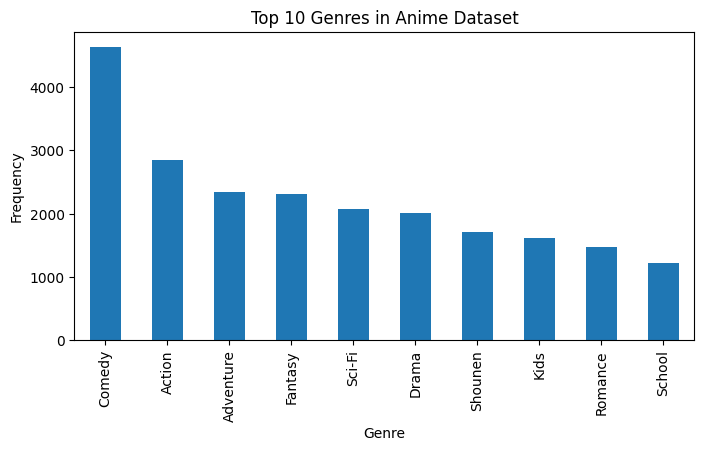

In [18]:
# a. Genre Analysis

genres_series = anime['genre'].dropna().str.split(', ')
all_genres = [genre for sublist in genres_series for genre in sublist]
genre_counts = pd.Series(all_genres).value_counts()
print("\nTop 10 Genres in Anime Dataset:")
print(genre_counts.head(10))

plt.figure(figsize=(8, 4))
plt.title("Top 10 Genres in Anime Dataset")
plt.xlabel("Genre")
plt.ylabel("Frequency")
# This bar chart visually confirms the dominance of certain genres,
# which can be incorporated as key features in a recommendation model
genre_counts.head(10).plot(kind='bar')
plt.show()

The plot above shows the most recurrent genres. Comedy is the one that is most present in the dataset, followed by action and adventure.

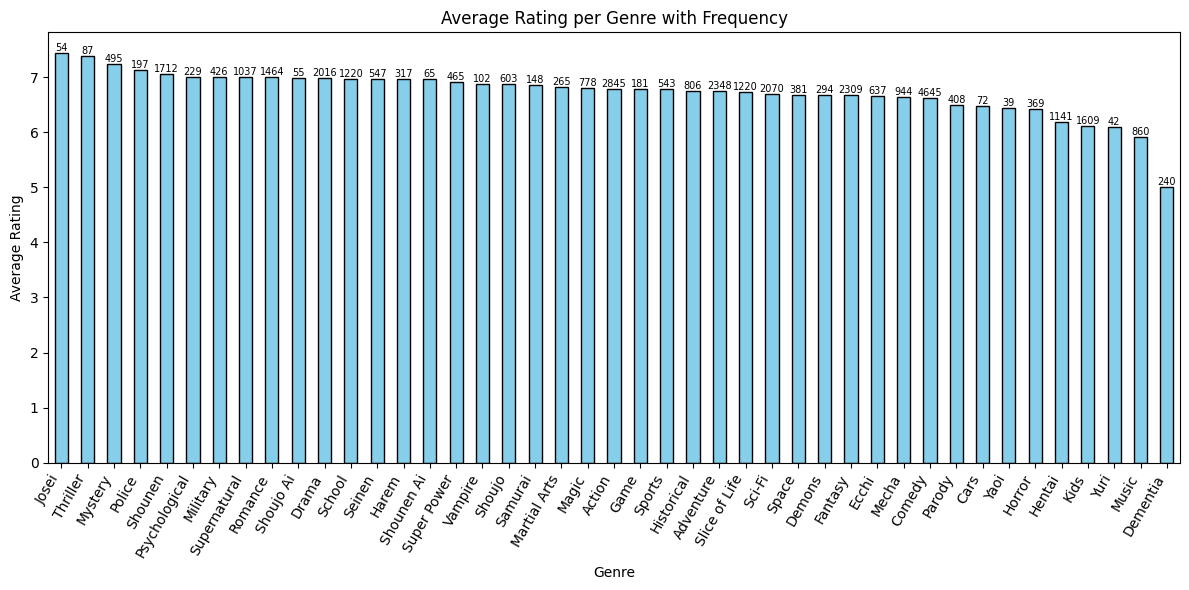

In [32]:
# Split the 'genre' column into individual genres and explode the dataframe
anime_genres_exploded = anime.dropna(subset=['genre']).copy()
anime_genres_exploded['genre'] = anime_genres_exploded['genre'].str.split(', ')
anime_genres_exploded = anime_genres_exploded.explode('genre')

# Calculate the average rating per genre
average_rating_per_genre = anime_genres_exploded.groupby('genre')['rating'].mean().sort_values(ascending=False)

# Get the frequency of each genre
genre_frequency = genre_counts.loc[average_rating_per_genre.index]


# Plot the average rating per genre
plt.figure(figsize=(12, 6))
bars = average_rating_per_genre.plot(kind='bar', color='skyblue', edgecolor='black')

# Add frequency labels on top of each bar
for bar, freq in zip(bars.patches, genre_frequency):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{freq}', 
             ha='center', va='bottom', fontsize=7)
    
plt.title("Average Rating per Genre with Frequency")
plt.xlabel("Genre")
plt.ylabel("Average Rating")
plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()


Here we can see that the most present genres actually do not necessarily have the best ratings. In fact, the genres with the best average rating have a relatively low count (makes sense because the more present a genre is, the more chances there are for it go get both good and bad ratings). Nonetheless, all the gegnres have very similar average ratings, around 7, with only Music and Dementia dropping below the rest (still not a very significant drop). This aligns with what we saw initially about the ratings left-skewed distribution.


Anime Types Distribution:
TV         3787
OVA        3311
Movie      2348
Special    1676
ONA         659
Music       488
Name: type, dtype: int64


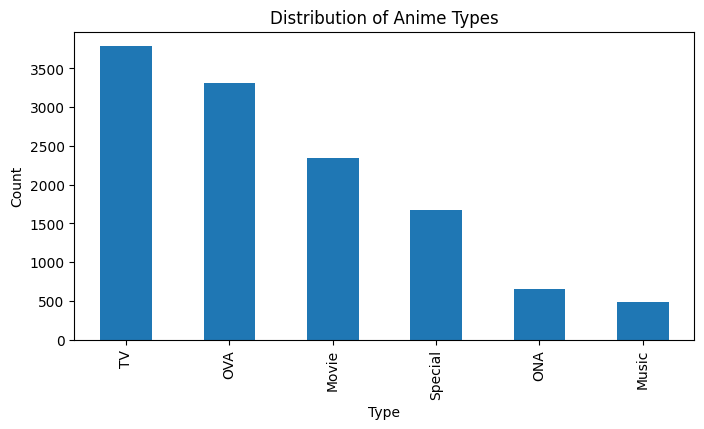

In [33]:
# b. Anime Type Distribution

type_counts = anime['type'].value_counts()
print("\nAnime Types Distribution:")
print(type_counts)
plt.figure(figsize=(8, 4))
plt.title("Distribution of Anime Types")
plt.xlabel("Type")
plt.ylabel("Count")
# This visualization helps us understand content type distribution,
# which may be used to segment or filter recommendations based on user interests
type_counts.plot(kind='bar')
plt.show()

The bar chart shows that TV series are the most common in the dataset. Knowing this could allow us to tailor recommendations accordingly and also handle type-specific filtering if a user has a clear preference

In [35]:
# c. Episodes Distribution

# c.1. Look at unique values of episodes to understand and group for visualizing in a clearer way
unique_episodes = anime['episodes'].unique()
print(unique_episodes)

['1' '64' '51' '24' '10' '148' '110' '13' '201' '25' '22' '75' '4' '26'
 '12' '27' '43' '74' '37' '2' '11' '99' 'Unknown' '39' '101' '47' '50'
 '62' '33' '112' '23' '3' '94' '6' '8' '14' '7' '40' '15' '203' '77' '291'
 '120' '102' '96' '38' '79' '175' '103' '70' '153' '45' '5' '21' '63' '52'
 '28' '145' '36' '69' '60' '178' '114' '35' '61' '34' '109' '20' '9' '49'
 '366' '97' '48' '78' '358' '155' '104' '113' '54' '167' '161' '42' '142'
 '31' '373' '220' '46' '195' '17' '1787' '73' '147' '127' '16' '19' '98'
 '150' '76' '53' '124' '29' '115' '224' '44' '58' '93' '154' '92' '67'
 '172' '86' '30' '276' '59' '72' '330' '41' '105' '128' '137' '56' '55'
 '65' '243' '193' '18' '191' '180' '91' '192' '66' '182' '32' '164' '100'
 '296' '694' '95' '68' '117' '151' '130' '87' '170' '119' '84' '108' '156'
 '140' '331' '305' '300' '510' '200' '88' '1471' '526' '143' '726' '136'
 '1818' '237' '1428' '365' '163' '283' '71' '260' '199' '225' '312' '240'
 '1306' '1565' '773' '1274' '90' '475' '263' '8

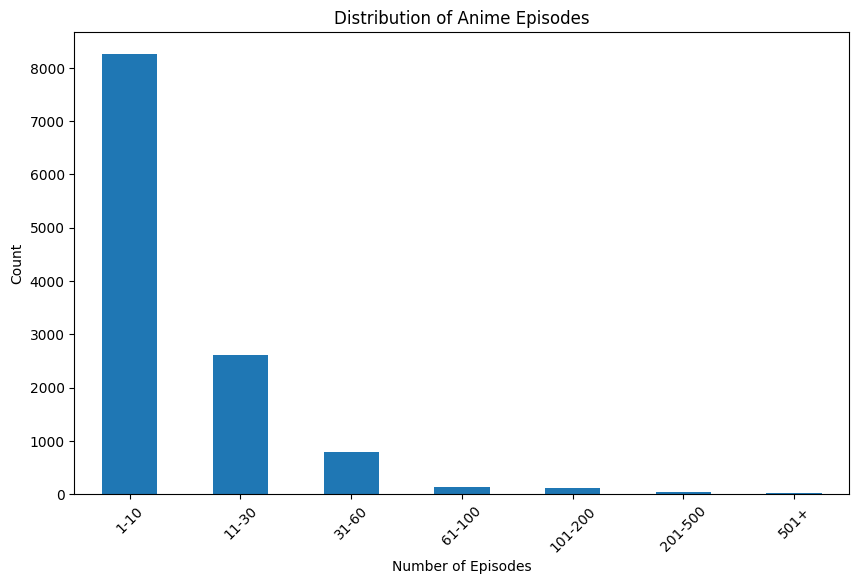

In [37]:
# c.2. Visualize

# Define the bin ranges for episodes
bins = [0, 10, 30, 60, 100, 200, 500, float('inf')]
labels = ['1-10', '11-30', '31-60', '61-100', '101-200', '201-500', '501+']

# Create a new column with the episode ranges
anime['episodes'] = pd.to_numeric(anime['episodes'], errors='coerce')
anime['episode_group'] = pd.cut(anime['episodes'], bins=bins, labels=labels)

# Plot the distribution
plt.figure(figsize=(10, 6))
anime['episode_group'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Anime Episodes')
plt.xlabel('Number of Episodes')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


The histogram of episodes indicates that most anime have between 1-10 episodes, some between 11-60 and very few have more than this. A few anime have an extremely high number of episodes, beyond 500. The number of episodes can serve as a proxy for content depth and user commitment. It might be useful as a feature in assessing the viewing commitment required


Correlation Matrix for Numeric Columns in Anime Dataset:
          anime_id  episodes    rating   members
anime_id  1.000000 -0.072945 -0.284625 -0.080071
episodes -0.072945  1.000000  0.088761  0.056307
rating   -0.284625  0.088761  1.000000  0.387979
members  -0.080071  0.056307  0.387979  1.000000


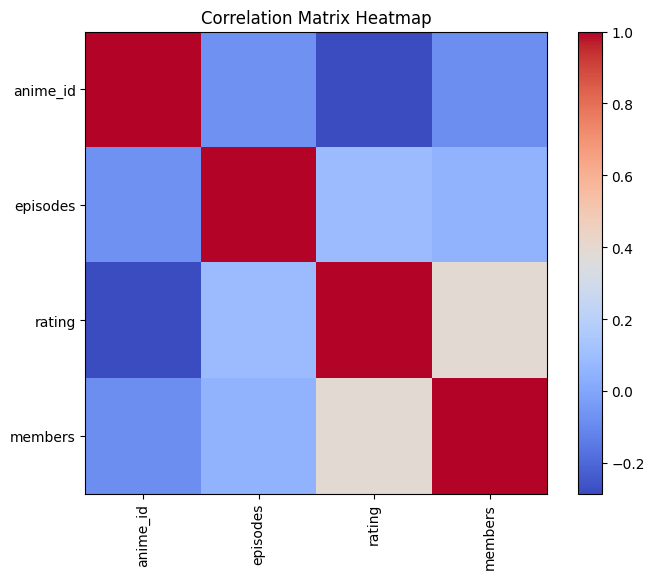

In [38]:
# d. Correlation Analysis among Numeric Columns in Anime Dataset

numeric_cols = anime.select_dtypes(include=[np.number]).columns
if len(numeric_cols) > 1:
    corr_matrix = anime[numeric_cols].corr()
    print("\nCorrelation Matrix for Numeric Columns in Anime Dataset:")
    print(corr_matrix)
    plt.figure(figsize=(8, 6))
    plt.imshow(corr_matrix, cmap='coolwarm', interpolation='none')
    plt.colorbar()
    plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=90)
    plt.yticks(range(len(numeric_cols)), numeric_cols)
    plt.title("Correlation Matrix Heatmap")
    plt.show()

The heatmap of the correlation matrix reveals the relationships between numeric features. However, there are no significant correlation values, they are all below 0.4. Still, less correlated features reduce redundancy and may improve model performance

## Merging Datasets for Further Analysis

In [51]:
# Merge ratings and anime datasets on 'anime_id'
merged_df = pd.merge(ratings, anime, on='anime_id', how='inner')

merged_df = merged_df.drop(columns=['rating_y']) # rating_y is the average rating coming from the anime dataset, we now want to focus on actual ratings from users

# Compute the average user rating for each anime using the merged dataset
# This average rating can be used as a baseline for recommendation models
avg_rating = merged_df.groupby('anime_id')['rating_x'].mean().reset_index() 
avg_rating.columns = ['anime_id', 'avg_user_rating']

# Merge the average ratings back into the anime dataset for further analysis
anime_with_avg = pd.merge(anime, avg_rating, on='anime_id', how='left')

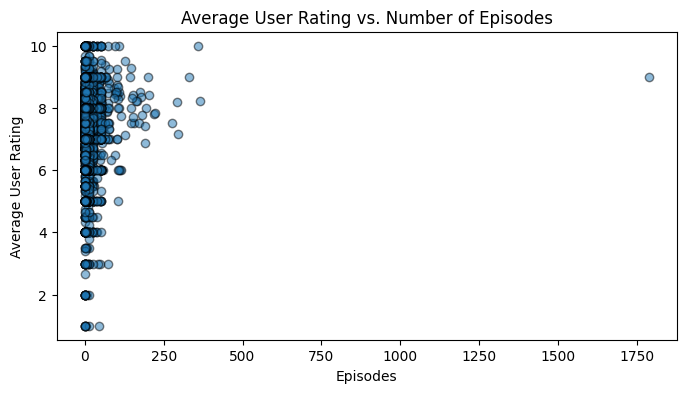

In [52]:
# Relationship between average user rating and number of episodes

plt.figure(figsize=(8, 4))
plt.scatter(anime_with_avg['episodes'], anime_with_avg['avg_user_rating'], alpha=0.5, edgecolor='black')
plt.title("Average User Rating vs. Number of Episodes")
plt.xlabel("Episodes")
plt.ylabel("Average User Rating")
plt.show()

No clear relationship between number of episodes and average rating. However, as we get more data in the future, this relationship can keep on being studied to inform feature engineering by highlighting an optimal range of content length.

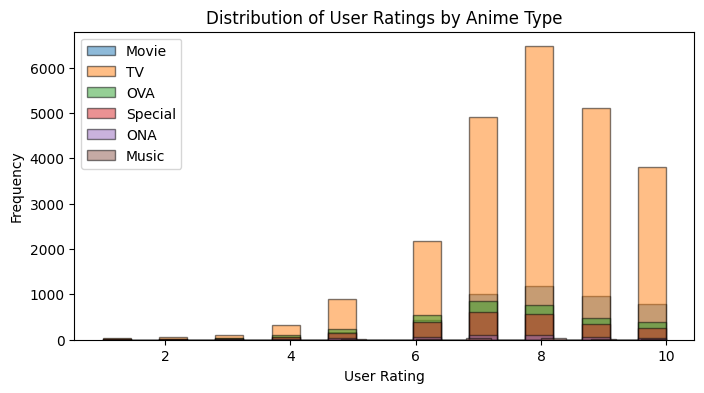

In [55]:
# User ratings broken down by anime type

plt.figure(figsize=(8, 4))
unique_types = merged_df['type'].dropna().unique()
for t in unique_types:
    subset = merged_df[merged_df['type'] == t]
    plt.hist(subset['rating_x'], bins=20, alpha=0.5, edgecolor='black', label=str(t))
plt.title("Distribution of User Ratings by Anime Type")
plt.xlabel("User Rating")
plt.ylabel("Frequency")
plt.legend()
plt.show()

We can see very similar overall distributions, with slight variations, and this suggests that while user perception is consistent, there may be subtle differences in rating patterns that can be exploited by a recommendation system to personalize suggestions. 

## Final Comments:

-  The concentrated distribution of ratings (mostly moderate-high values) suggests that users have a common baseline, implying that normalization and bias adjustment could be useful in rating prediction.

- The heavy-tailed distribution of rating counts per anime highlights a popularity bias and potential cold-start issues. Addressing these through hybrid models or incorporating content-based features (like genres) can improve recommendations.

- Genre analysis confirms that certain genres dominate, which can be used to build content-based filtering methods, enhancing personalization by aligning recommendations with users' genre preferences. However, we must be careful not to bias towards the more common genres and ensure users with niche preferences are recommended items they will enjoy.

- The overwhelming presence of TV series in the dataset means the model should give special consideration to TV anime, perhaps even designing type-specific recommendation rules in the future if proven necessary.

- Episode counts provide insight into content depth and user commitment, which might be leveraged as an additional feature to predict user satisfaction and tailor recommendations based on viewing time constraints.
